<a href="https://colab.research.google.com/github/Epilef86/Clusterizacao_Pratica/blob/main/Lojista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

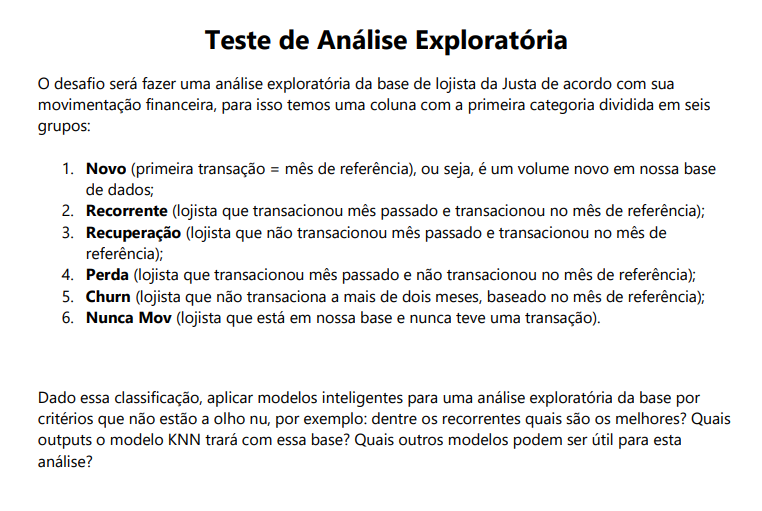

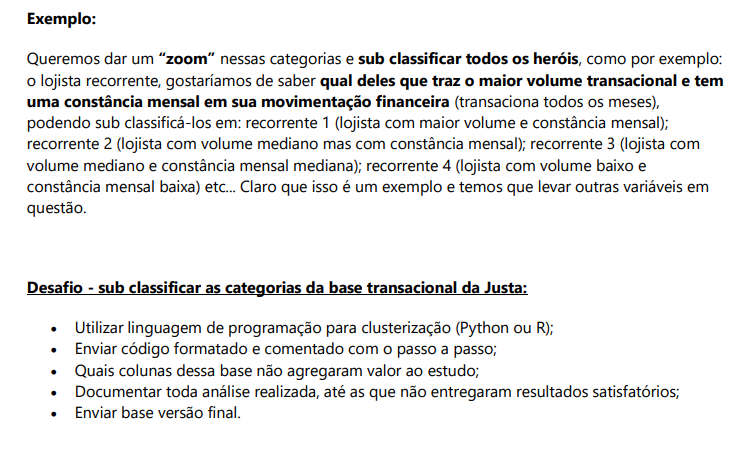

Instalar a biblioteca sidetable serve pra facilitar a contagem dos valores e mostrar os valores ausentes (missing values)

In [986]:
%%capture
%pip install sidetable

Bibliotecas de Data Wrangling

In [987]:
# Data wrangling
import numpy as np
import pandas as pd
import sidetable

Bibliotecas de visualização de dados

In [988]:
# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

Importando bibliotecas de machine learning

In [989]:
## -- Machine learning -- ##
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster import kelbow_visualizer

A célula abaixo vai estar configurando as figuras, deixando os gráficos estaticamente mais atraentes

In [990]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

Data Understanding

In [991]:
df_lojista = pd.read_excel('/content/base_analise_exploratoria.xlsx')

df_lojista.head()

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0
2,90,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,21.0
3,94,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,NaN
4,94,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Nunca Mov,NaN


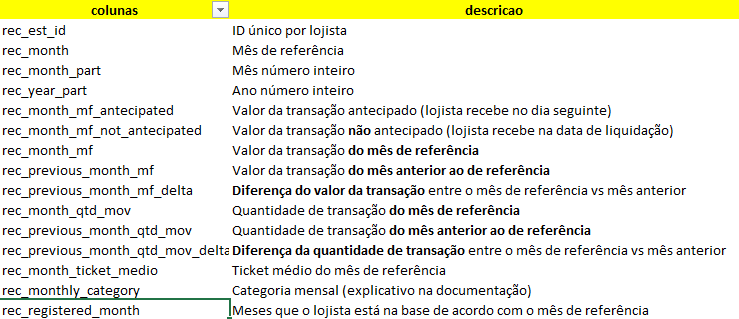

Data Cleaning

In [992]:
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205363 entries, 0 to 205362
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   rec_est_id                        205363 non-null  int64         
 1   rec_month                         205363 non-null  datetime64[ns]
 2   rec_month_part                    205363 non-null  int64         
 3   rec_year_part                     205363 non-null  int64         
 4   rec_month_mf_antecipated          205363 non-null  float64       
 5   rec_month_mf_not_antecipated      205363 non-null  float64       
 6   rec_month_mf                      205363 non-null  float64       
 7   rec_previous_month_mf             205363 non-null  float64       
 8   rec_previous_month_mf_delta       205363 non-null  float64       
 9   rec_month_qtd_mov                 205363 non-null  int64         
 10  rec_previous_month_qtd_mov      

Mais a frente irei mudar a coluna "rec_registered_month" de float para int. Também se verifica que existem valores nulos nela.

Analisando a coluna "rec_monthly_category" pra saber o porquê que ela está como object/string

In [993]:
df_lojista.rec_monthly_category.sort_values()

0               Churn
107060          Churn
107059          Churn
107058          Churn
107057          Churn
             ...     
120544    Recuperação
120561    Recuperação
70135     Recuperação
45498     Recuperação
26462     Recuperação
Name: rec_monthly_category, Length: 205363, dtype: object

In [994]:
#Fiz só pra testar filtrando apenas valores que contenha 'Recuperação'
#df_lojista[(df_lojista['rec_monthly_category'] == 'Recuperação')]

In [995]:
#Verificando a quantidade de cada categoria dos lojistas.

df_lojista.rec_monthly_category.value_counts()

Churn          103883
Nunca Mov       77845
Recorrente      13494
Perda            5728
Novo             2917
Recuperação      1496
Name: rec_monthly_category, dtype: int64

Verificando o percentual de cada categoria via gráfico

<Axes: >

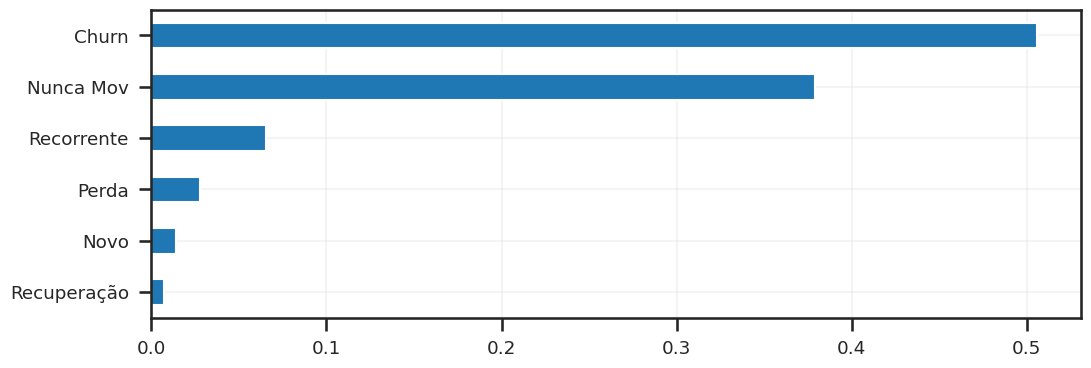

In [996]:
df_lojista['rec_monthly_category'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,4))

Descobrindo a primeira e última data

In [997]:
df_lojista.rec_month.agg(['min','max'])

min   2022-01-01
max   2023-02-01
Name: rec_month, dtype: datetime64[ns]

Criando duas variáveis diferentes para armazenar os dados do ano de 2022 e do ano de 2023.

In [998]:
df_2022 = df_lojista[df_lojista['rec_month'].dt.year == 2022]
df_2023 = df_lojista[df_lojista['rec_month'].dt.year == 2023]

Agrupando os dados de cada ano pela nova coluna MesAno e somando os valores da coluna de faturamento para cada mês:

In [999]:
df_agg_2022 = df_2022.groupby('rec_month_part')['rec_month_mf'].sum().reset_index()
df_agg_2023 = df_2023.groupby('rec_month_part')['rec_month_mf'].sum().reset_index()

Criando dois gráficos de barras separados, um para o ano de 2022 e outro para o ano de 2023. Cada gráfico mostrará a soma mensal do faturamento para cada mês do respectivo ano.

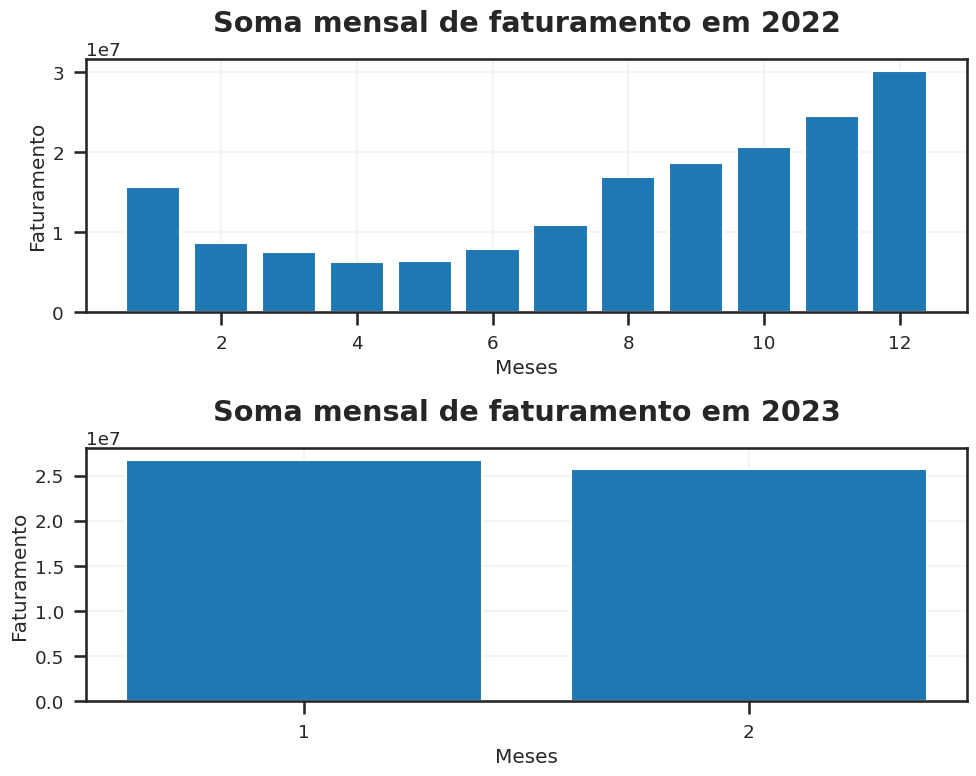

In [1028]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.bar(df_agg_2022['rec_month_part'], df_agg_2022['rec_month_mf'])
ax1.set_title('Soma mensal de faturamento em 2022')
ax1.set_xlabel('Meses')
ax1.set_ylabel('Faturamento')
# Define as etiquetas do eixo x como o número inteiro correspondente a cada mês
plt.xticks(range(1, 13), range(1, 13))

ax2.bar(df_agg_2023['rec_month_part'], df_agg_2023['rec_month_mf'])
ax2.set_title('Soma mensal de faturamento em 2023')
ax2.set_xlabel('Meses')
ax2.set_ylabel('Faturamento')
# Define as etiquetas do eixo x como o número inteiro correspondente a cada mês
plt.xticks(range(1, 3), range(1, 3))

plt.tight_layout()
plt.show()

Criando um filtro apenas dos grupos que fizeram transações no mês atual da coluna "rec_monthly_category" 

In [1001]:
# Filtra apenas nas linhas aonde teve transações do mês atual
filtro = df_lojista.loc[
    (df_lojista['rec_monthly_category'] == 'Novo') | (df_lojista['rec_monthly_category'] == 'Recorrente') |
    (df_lojista['rec_monthly_category'] == 'Recuperação')
    ]

Analisando essas 02 colunas abaixo, pois é importante saber se a empresa tem caixa pra repor o mês atual, ou seja, consiga pagar todos os custos operacionais, caso se tenha muitos valores não antecipados.

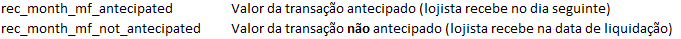

In [1002]:
filtro[['rec_month_mf_antecipated','rec_month_mf_not_antecipated']].describe()

,rec_month_mf_antecipated,rec_month_mf_not_antecipated
count,17907.000000,17907.000000
mean,9619.058847,3034.405067
std,34168.452969,18515.849015
min,0.000000,0.000000
25%,53.000000,0.000000
50%,1800.000000,0.000000
75%,8305.500000,0.000000
max,814475.400000,588157.520000


O desvio é o quanto o valor é disperso da média. Quanto maior o desvio padrão a média não explica tão bem, do inverso também. Nesse caso o desvio padrão foi muito alto devido a outliers

<Axes: >

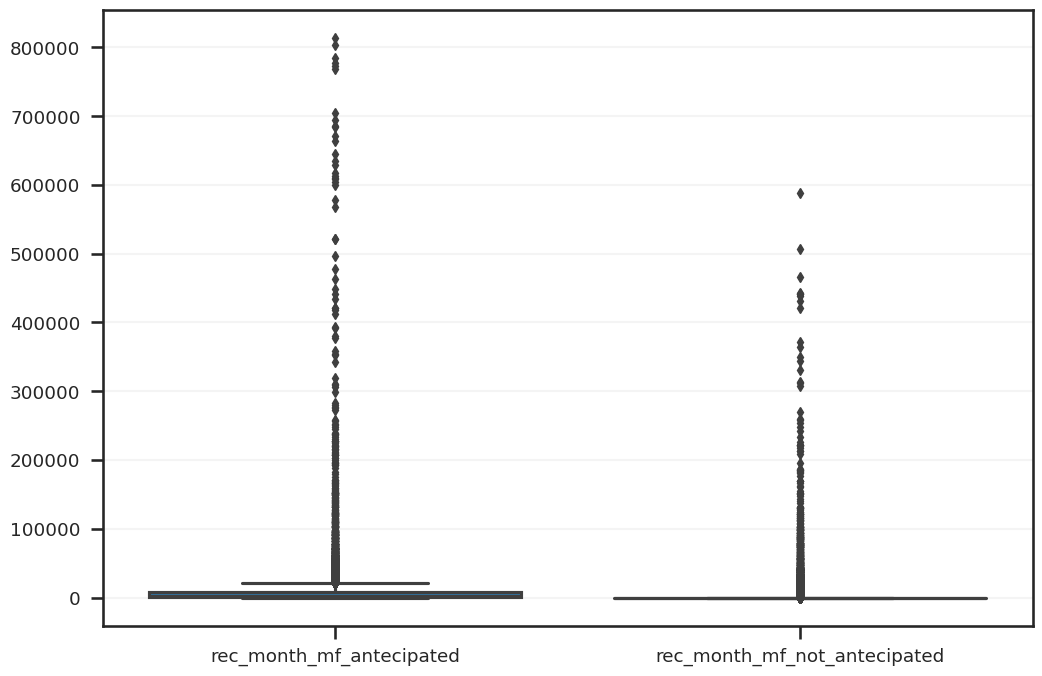

In [1003]:
sns.boxplot(filtro[['rec_month_mf_antecipated','rec_month_mf_not_antecipated']])

O eixo y são os valores das transações, verifica-se muitos outliers

In [1004]:
# Filtrando um cliente aleatório com o ID igual a 44 pra fazer uma análise da distribuição dos dados
df_lojista[df_lojista['rec_est_id'] == 44]



,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0
21887,44,2023-02-01,2,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,58.0
41718,44,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45.0
41719,44,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,50.0
52794,44,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47.0
74764,44,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,49.0
90143,44,2022-11-01,11,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,55.0
95024,44,2023-01-01,1,2023,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,57.0
113813,44,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,51.0


Ordenando as datas e o ID ao mesmo tempo

In [1005]:
df_lojista.sort_values(['rec_est_id', 'rec_month'], ascending=[True, True], inplace=True)

Verificando novamente esse cliente, que foi um cliente aleatório

In [1006]:
# Filtra o cliente com o ID igual a 44
df_lojista[df_lojista['rec_est_id'] == 44]


,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month
41718,44,2022-01-01,1,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45.0
170187,44,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46.0
52794,44,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47.0
192775,44,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48.0
74764,44,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,49.0
41719,44,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,50.0
113813,44,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,51.0
0,44,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,52.0
183228,44,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,53.0
1,44,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,54.0


Observe que o cliente teve seu primeiro registro há 45 meses atrás contados a partir de janeiro de 2022, isso pode ser visto na coluna "rec_registered_month" logo o dataset disponibilizado pela autor está incompleto, possuindo dados apenas a partir de janeiro de 2022. 

Vou excluir os clientes que TODOS os itens são do mesmo tipo "Churn" ou apenas "Nunca Mov" porque eles não fizeram transações nesses períodos. O de "Perda" não vou excluir porque ele só não movimentou um mês antes do mês de referência, porém fez transações.

In [1007]:
# Identificar os IDs que possuem única e exclusivamente o valor 'Churn' na coluna de rec_registered_month
id_to_remove = df_lojista.groupby('rec_est_id')['rec_monthly_category'].unique().apply(lambda x: len(x) == 1 and 'Churn' in x).loc[lambda x: x].index

# Nesse código, é feito um filtro selecionando os ids que possuem apenas um valor único como categoria e essa valor é justamente 'Churn'.

# Remover as linhas desses IDs do dataframe
df_lojista = df_lojista[~df_lojista['rec_est_id'].isin(id_to_remove)]

In [1008]:
# Verificando se o cliente com o ID igual a 44 ainda está no dataset
df_lojista[df_lojista['rec_est_id'] == 44]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month


Excluindo os clientes aonde todos os itens são "Nunca Mov"

In [1009]:
# Identificar os IDs que possuem única e exclusivamente o valor 'Churn' na coluna de rec_registered_month
id_to_remove = df_lojista.groupby('rec_est_id')['rec_monthly_category'].unique().apply(lambda x: len(x) == 1 and 'Nunca Mov' in x).loc[lambda x: x].index

# Nesse código, é feito um filtro selecionando os ids que possuem apenas um valor único como categoria e essa valor é justamente 'Churn'.

# Remover as linhas desses IDs do dataframe
df_lojista = df_lojista[~df_lojista['rec_est_id'].isin(id_to_remove)]

Verificando quantos dados existem no meu dataset

In [1010]:
df_lojista.shape

(63320, 15)

Verificando se tem valores nulos

In [1011]:
df_lojista.isna().sum().sort_values(ascending=False)

rec_est_id                          0
rec_month                           0
rec_month_part                      0
rec_year_part                       0
rec_month_mf_antecipated            0
rec_month_mf_not_antecipated        0
rec_month_mf                        0
rec_previous_month_mf               0
rec_previous_month_mf_delta         0
rec_month_qtd_mov                   0
rec_previous_month_qtd_mov          0
rec_previous_month_qtd_mov_delta    0
rec_month_ticket_medio              0
rec_monthly_category                0
rec_registered_month                0
dtype: int64

Verificando se têm linhas duplicadas no dataset

In [1012]:
df_lojista.duplicated().sum()

0

In [1013]:
# converter a coluna "rec_registered_month" para int
df_lojista['rec_registered_month'] = df_lojista['rec_registered_month'].astype(int)

<ipython-input-1013-fba158c7d04f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lojista['rec_registered_month'] = df_lojista['rec_registered_month'].astype(int)


In [1014]:
#Verificando se foi feita a conversão de float para inteiro na coluna "rec_registered_month"
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63320 entries, 185071 to 27686
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rec_est_id                        63320 non-null  int64         
 1   rec_month                         63320 non-null  datetime64[ns]
 2   rec_month_part                    63320 non-null  int64         
 3   rec_year_part                     63320 non-null  int64         
 4   rec_month_mf_antecipated          63320 non-null  float64       
 5   rec_month_mf_not_antecipated      63320 non-null  float64       
 6   rec_month_mf                      63320 non-null  float64       
 7   rec_previous_month_mf             63320 non-null  float64       
 8   rec_previous_month_mf_delta       63320 non-null  float64       
 9   rec_month_qtd_mov                 63320 non-null  int64         
 10  rec_previous_month_qtd_mov        63320 n

Verificando novamente a primeira e última data

In [1015]:
df_lojista.rec_month.agg(['min','max'])

min   2022-01-01
max   2023-02-01
Name: rec_month, dtype: datetime64[ns]

Verificando quais clientes que foram de dezembro de 2021 que se tornaram perda em janeiro de *2022*

In [1016]:
filtro_perda = (df_lojista['rec_month'] == '2022-01-01') & (df_lojista['rec_monthly_category'] == 'Perda')

df_filtrado = df_lojista.loc[filtro_perda]

In [1017]:
df_filtrado.shape

(1050, 15)

Excluir os clientes que foram perda em janeiro de 2022 e Churn nos demais meses a partir de fevereiro de *2022* porque eles não estão fazendo nenhuma transação

Criando uma nova coluna chamada "rec_status" aonde todos os itens possuem valor ativo

In [1018]:
df_lojista['rec_status'] = 'ativo'

In [1019]:
#verificando o status de um cliente aleatório
df_lojista[df_lojista['rec_est_id']==368]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_status
105009,368,2022-01-01,1,2022,0.0,0.0,0.0,8744.0,-8744.0,0,13,-13,0.0,Perda,39,ativo
113928,368,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,40,ativo
50,368,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,41,ativo
183330,368,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,42,ativo
1381,368,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,43,ativo
105010,368,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,44,ativo
170282,368,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45,ativo
53338,368,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46,ativo
128484,368,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47,ativo
53339,368,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48,ativo


Utilizando o método loc para selecionar as linhas onde a coluna "rec_monthly_category" contém os valores "Churn" ou "Perda" e, em seguida, atribua o valor "inativo" na coluna chamada de "rec_status":

In [1020]:
# seleciona as linhas onde rec_status é igual a "Churn" ou "Perda" e atribui "inativo" à coluna rec_status
df_lojista.loc[df_lojista['rec_monthly_category'].isin(['Churn', 'Perda']), 'rec_status'] = 'inativo'

Verifique se a coluna "rec_status" foi atualizada corretamente:

In [1021]:
# exibe as primeiras linhas do DataFrame para verificar se a coluna foi atualizada corretamente
df_lojista.head()

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_status
185071,1,2022-01-01,1,2022,838.80,0.00,838.80,0.00,838.80,5,0,5,167.76,Recuperação,24,ativo
185067,1,2022-02-01,2,2022,7802.59,0.00,7802.59,838.80,6963.79,93,5,88,83.90,Recorrente,25,ativo
190800,1,2022-03-01,3,2022,2.00,0.00,2.00,7802.59,-7800.59,2,93,-91,1.00,Recorrente,26,ativo
185070,1,2022-04-01,4,2022,0.00,1000.00,1000.00,2.00,998.00,1,2,-1,1000.00,Recorrente,27,ativo
192772,1,2022-05-01,5,2022,0.00,1165.74,1165.74,1000.00,165.74,2,1,1,582.87,Recorrente,28,ativo


In [1022]:
#verificando novamente esse cliente pra ver se houve alteração no seu status de acordo com sua categoria
df_lojista[df_lojista['rec_est_id']==368]

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_status
105009,368,2022-01-01,1,2022,0.0,0.0,0.0,8744.0,-8744.0,0,13,-13,0.0,Perda,39,inativo
113928,368,2022-02-01,2,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,40,inativo
50,368,2022-03-01,3,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,41,inativo
183330,368,2022-04-01,4,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,42,inativo
1381,368,2022-05-01,5,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,43,inativo
105010,368,2022-06-01,6,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,44,inativo
170282,368,2022-07-01,7,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,45,inativo
53338,368,2022-08-01,8,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,46,inativo
128484,368,2022-09-01,9,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,47,inativo
53339,368,2022-10-01,10,2022,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,Churn,48,inativo


In [1023]:
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63320 entries, 185071 to 27686
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rec_est_id                        63320 non-null  int64         
 1   rec_month                         63320 non-null  datetime64[ns]
 2   rec_month_part                    63320 non-null  int64         
 3   rec_year_part                     63320 non-null  int64         
 4   rec_month_mf_antecipated          63320 non-null  float64       
 5   rec_month_mf_not_antecipated      63320 non-null  float64       
 6   rec_month_mf                      63320 non-null  float64       
 7   rec_previous_month_mf             63320 non-null  float64       
 8   rec_previous_month_mf_delta       63320 non-null  float64       
 9   rec_month_qtd_mov                 63320 non-null  int64         
 10  rec_previous_month_qtd_mov        63320 n


Excluir todos os clientes com o mesmo ID que possuem TODAS as linhas da coluna 'rec_status' como INATIVOS em um DataFrame Pandas:

In [1024]:
# Identificar os IDs que possuem única e exclusivamente o valor 'inativo' na coluna de rec_status
id_to_remove = df_lojista.groupby('rec_est_id')['rec_status'].unique().apply(lambda x: len(x) == 1 and 'inativo' in x).loc[lambda x: x].index

# Nesse código, é feito um filtro selecionando os ids que possuem apenas um valor único como categoria e essa valor é justamente 'Churn'.

# Remover as linhas desses IDs do dataframe
df_lojista = df_lojista[~df_lojista['rec_est_id'].isin(id_to_remove)]

In [1025]:
#verificando se houve exclusão
df_lojista.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53071 entries, 185071 to 27686
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rec_est_id                        53071 non-null  int64         
 1   rec_month                         53071 non-null  datetime64[ns]
 2   rec_month_part                    53071 non-null  int64         
 3   rec_year_part                     53071 non-null  int64         
 4   rec_month_mf_antecipated          53071 non-null  float64       
 5   rec_month_mf_not_antecipated      53071 non-null  float64       
 6   rec_month_mf                      53071 non-null  float64       
 7   rec_previous_month_mf             53071 non-null  float64       
 8   rec_previous_month_mf_delta       53071 non-null  float64       
 9   rec_month_qtd_mov                 53071 non-null  int64         
 10  rec_previous_month_qtd_mov        53071 n

Aplicando clusterização através das métricas RFM:

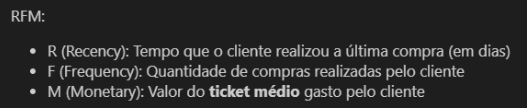

R --> recência:

tempo atual - tempo da última compra em dias

In [1030]:
#tempo atual
pd.Timestamp.today()

Timestamp('2023-03-30 20:40:47.522851')

F --> frequência se calcula verificando quantos itens foi comprado no total ou quantos pedidos foi solicitado no total. Depende da estratégia que se queira usar.
Verificar quantos pedidos únicos foram feitos. Lembrando que pedido para cada produto pode ter múltiplos produtos com múltiplas quantidades;

M --> monetary

Ticket Médio preço total e a média

Agrupando pelo ID cliente. 

Dentro da função .agg irei passar os parâmetros de uma tupla: 

1- nome da coluna que existe no dataset;

2- função aplicada a cada cliente.

Quero pegar a data de hoje menos a data da última conta para cada cliente em dias.


In [1032]:
df_rfm = (
  df_lojista.groupby('rec_est_id')
  .agg(
      R = ('rec_month', lambda x: (pd.Timestamp.today() - x.max()).days),
      F = ('rec_month_qtd_mov', 'nunique'),
      M = ('rec_month_ticket_medio', 'mean')
  )
)

df_rfm

,R,F,M
rec_est_id,,,
1,57,10,1122.776429
49,57,4,17.900714
89,57,4,48.492143
109,57,2,0.392857
112,57,5,33.180000
...,...,...,...
30481,57,1,5.000000
30484,57,1,0.100000
30503,57,1,110.000000


A tabela de R F M, estão em escalas diferentes, por este motivo os valores estão bem distintos. Escalonando usando a função scale.

Vemos que todos tem outlier, o eixo y é o desvio padrão..

<Axes: >

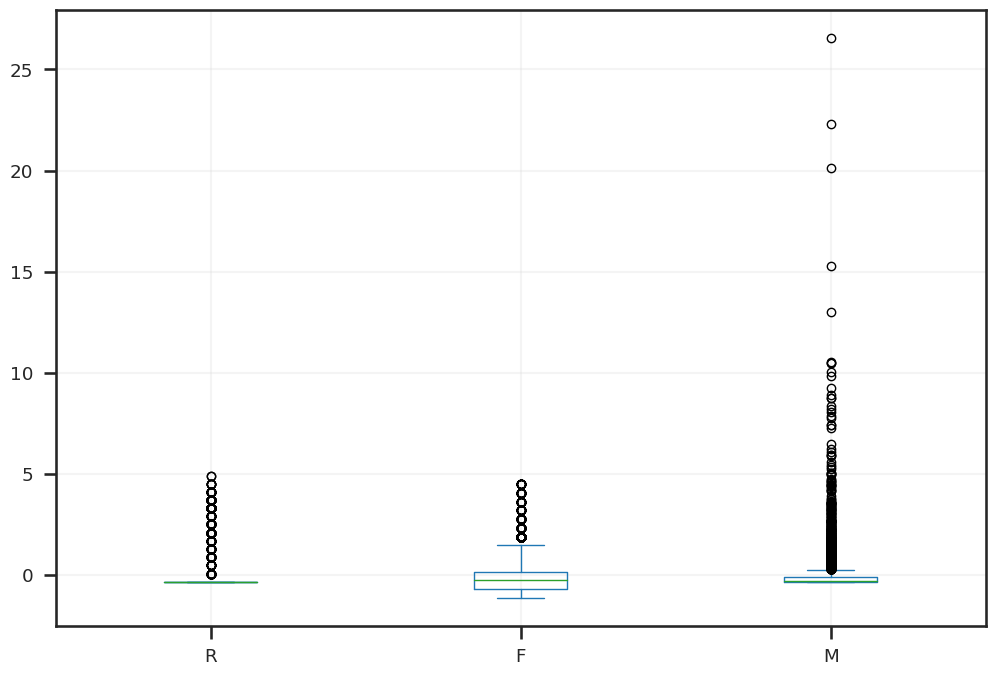

In [1033]:
df_rfm.apply(scale).plot.box()

Verificando o outlier > 10

In [1034]:
df_rfm.apply(scale).query('M>10')

,R,F,M
rec_est_id,,,
23174,-0.33254,0.178403,15.259974
23404,-0.33254,1.905676,26.567031
26078,-0.33254,0.178403,10.559748
28547,-0.33254,-1.117051,20.120295
28627,-0.33254,-0.253415,10.503446
28898,-0.33254,0.178403,13.001308
29780,-0.33254,-0.685233,22.285609
30163,-0.33254,-1.117051,10.044946
30407,-0.33254,-1.117051,10.494284


Verificando quem são esses clientes:

In [1037]:
df_lojista.query('rec_est_id==23174')

,rec_est_id,rec_month,rec_month_part,rec_year_part,rec_month_mf_antecipated,rec_month_mf_not_antecipated,rec_month_mf,rec_previous_month_mf,rec_previous_month_mf_delta,rec_month_qtd_mov,rec_previous_month_qtd_mov,rec_previous_month_qtd_mov_delta,rec_month_ticket_medio,rec_monthly_category,rec_registered_month,rec_status
188292,23174,2022-05-01,5,2022,0.0,247283.68,247283.68,0.00,247283.68,9,0,9,27475.96,Novo,0,ativo
181665,23174,2022-06-01,6,2022,0.0,130600.00,130600.00,247283.68,-116683.68,4,9,-5,32650.00,Recorrente,1,ativo
165145,23174,2022-07-01,7,2022,0.0,466085.00,466085.00,130600.00,335485.00,15,4,11,31072.33,Recorrente,2,ativo
169505,23174,2022-08-01,8,2022,0.0,259325.02,259325.02,466085.00,-206759.98,9,15,-6,28813.89,Recorrente,3,ativo
165137,23174,2022-09-01,9,2022,0.0,0.00,0.00,259325.02,-259325.02,0,9,-9,0.00,Perda,4,inativo
169506,23174,2022-10-01,10,2022,0.0,0.00,0.00,0.00,0.00,0,0,0,0.00,Churn,5,inativo
194323,23174,2022-11-01,11,2022,0.0,0.00,0.00,0.00,0.00,0,0,0,0.00,Churn,6,inativo
29762,23174,2022-12-01,12,2022,0.0,0.00,0.00,0.00,0.00,0,0,0,0.00,Churn,7,inativo
63954,23174,2023-01-01,1,2023,0.0,0.00,0.00,0.00,0.00,0,0,0,0.00,Churn,8,inativo
12115,23174,2023-02-01,2,2023,0.0,0.00,0.00,0.00,0.00,0,0,0,0.00,Churn,9,inativo


Excluo esse cliente ?

In [ ]:
df_rfm = df_rfm.drop(23174)